<a href="https://colab.research.google.com/github/Heoyuna0819/machine_learning/blob/main/WSDM_CNN%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [37]:
# 1. Load & Clean
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
df = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1_raw.txt",
                 header=None, names=names, comment=';')

df = df.drop(columns=["NaN"])
for col in ["x_axis", "y_axis", "z_axis"]:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(";", "", regex=True), errors="coerce")

df = df.dropna().reset_index(drop=True)

In [38]:
le = LabelEncoder()
df["activity_enc"] = le.fit_transform(df["activity"])

In [39]:
#2. Train/Test Split
df_train_users = df[df["user_id"] <= 18].copy()
df_val_users   = df[(df["user_id"] >= 19) & (df["user_id"] <= 20)].copy()
df_test_users  = df[(df["user_id"] > 20) & (df["user_id"] <= 36)].copy()

In [40]:
#3. Scaling
scaler = RobustScaler().fit(df_train_users[scale_cols])
for d in (df_train_users, df_val_users, df_test_users):
    d.loc[:, scale_cols] = scaler.transform(d[scale_cols])

In [41]:
#4. Label Encoding
le = LabelEncoder()
df_train["activity_enc"] = le.fit_transform(df_train["activity"])
df_test["activity_enc"]  = le.transform(df_test["activity"])

In [42]:
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_enc
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098199,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098200,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098201,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [43]:
#5. Sliding Window
def create_windows(X_df, y_ser, time_steps=200, step=40):
    X, y = [], []
    for i in range(0, len(X_df) - time_steps, step):
        block = X_df.iloc[i:i+time_steps].values
        labels = y_ser.iloc[i:i+time_steps].values
        vals, cnts = np.unique(labels, return_counts=True)
        major = vals[np.argmax(cnts)]
        X.append(block)
        y.append(major)
    return np.asarray(X), np.asarray(y).reshape(-1, 1)

TIME_STEPS, STEP = 200, 40
X_tr, y_tr = create_windows(df_train_users[scale_cols], df_train_users["activity_enc"], time_steps=200, step=40)
X_val, y_val = create_windows(df_val_users[scale_cols],   df_val_users["activity_enc"],   time_steps=200, step=40)
X_test, y_test = create_windows(df_test_users[scale_cols], df_test_users["activity_enc"], time_steps=200, step=40)

In [44]:
#6. Train/Valid Split
y_flat = y_train_all.flatten()
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_all, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

In [45]:
#7. One-Hot Encoding
enc = OneHotEncoder(sparse_output=False)
y_tr_oh  = enc.fit_transform(y_tr.reshape(-1,1))
y_val_oh = enc.transform(y_val.reshape(-1,1))
y_test_oh= enc.transform(y_test.reshape(-1,1))

n_timesteps, n_features = X_tr.shape[1], X_tr.shape[2]
n_classes = y_tr_oh.shape[1]
print("Input shape:", (n_timesteps, n_features), "Classes:", n_classes, le.classes_)

Input shape: (200, 3) Classes: 6 ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [46]:
#8. CNN + LSTM Model
inputs = keras.Input(shape=(n_timesteps, n_features))

# CNN 블록
x = keras.layers.Conv1D(64, 5, strides=1, padding="same", activation="relu")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)

x = keras.layers.Conv1D(96, 3, padding="same", activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(2)(x)

# LSTM 블록
x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=False, activation="tanh", recurrent_dropout=0.1)
    )(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(n_classes, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)

model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 200, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 200, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 100, 96)        │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,422 (470.40 KB)

 Trainable params: 119,846 (468.15 KB)

 Non-trainable params: 576 (2.25 KB)

In [47]:
#9. Callbacks
early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
rlr   = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor="val_loss")


In [48]:
#10. Train
history = model.fit(
    X_tr, y_tr_oh,
    validation_data=(X_val, y_val_oh),
    epochs=50,
    batch_size=64,
    callbacks=[early, rlr],
    verbose=1
)

Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.7811 - loss: 0.6002 - val_accuracy: 0.7859 - val_loss: 0.7799 - learning_rate: 0.0010
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9465 - loss: 0.1449 - val_accuracy: 0.9641 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.9712 - loss: 0.0785 - val_accuracy: 0.9817 - val_loss: 0.0523 - learning_rate: 0.0010
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 193ms/step - accuracy: 0.9813 - loss: 0.0555 - val_accuracy: 0.9788 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 41s 192ms/step - accuracy: 0.9867 - loss: 0.0405 - val_accuracy: 0.9823 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 36s 184ms/step - accuracy: 0.9870 - loss: 0.0390 - val_accuracy: 0.9859 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.9

In [51]:
#11. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_oh, batch_size=64, verbose=1)
print(f"[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")


186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8682 - loss: 1.0826
[Test] loss=1.5023  acc=0.8465


186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step

Classification Report (Test):
              precision    recall  f1-score   support

  Downstairs       0.62      0.74      0.67      1223
     Jogging       0.88      0.97      0.92      3755
     Sitting       0.91      0.83      0.87       560
    Standing       0.90      0.97      0.93       531
    Upstairs       0.71      0.68      0.70      1422
     Walking       0.93      0.81      0.87      4378

    accuracy                           0.85     11869
   macro avg       0.82      0.83      0.83     11869
weighted avg       0.85      0.85      0.85     11869



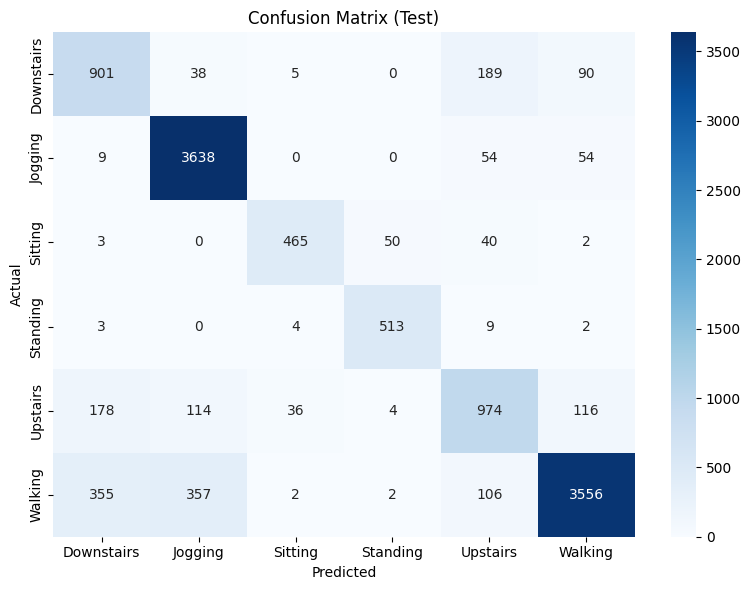

In [52]:
# ===== 12. Reports =====
y_pred_prob = model.predict(X_test, batch_size=64)
y_pred = y_pred_prob.argmax(axis=1)

print("\nClassification Report (Test):")
print(classification_report(y_test.flatten(), y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test.flatten(), y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()